### Importing the required libraries

In [21]:
import os
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

In [91]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split, DataLoader
import torchvision.transforms as transforms
from torch.nn.modules.dropout import Dropout
import torchvision
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns

### Reading the train data

#### Defining the train transforms

In [3]:
train_transform=transforms.Compose([transforms.ColorJitter(brightness=0.3, 
                          saturation=0.1, contrast=0.1),transforms.ToTensor()])

In [4]:
Train_data_path="../input/asl-alphabet/asl_alphabet_train/asl_alphabet_train"
train_data=ImageFolder(Train_data_path,transform=train_transform)

In [5]:
len(train_data)

87000

#### Initializing the train dataloader

In [6]:
def train_data_loader(data_train, batchsize):
    train_loader=DataLoader(dataset=data_train, 
                            batch_size=batchsize,
                            shuffle=True, num_workers=2)
    return train_loader

In [7]:
train_loader=train_data_loader(train_data,100)
classes=train_loader.dataset.classes

#### Visualizing 5 images in the train data and checking the size

Image size is torch.Size([100, 3, 200, 200])
Ground truth nothing


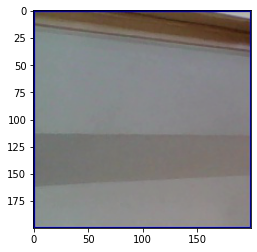

Image size is torch.Size([100, 3, 200, 200])
Ground truth D


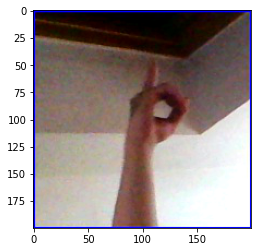

Image size is torch.Size([100, 3, 200, 200])
Ground truth T


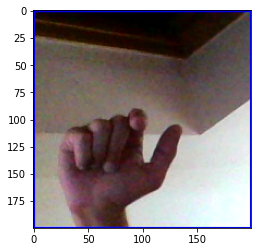

Image size is torch.Size([100, 3, 200, 200])
Ground truth V


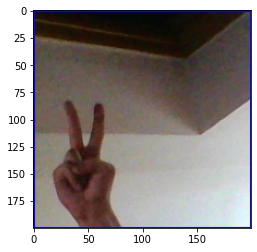

Image size is torch.Size([100, 3, 200, 200])
Ground truth K


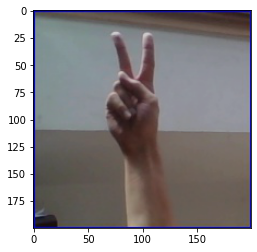

In [8]:
for i in range(5):
    for img, label in train_loader:
        print("Image size is {0}".format(img.shape))
        print('Ground truth', classes[label[0]])
        plt.imshow(img[0].permute(1, 2, 0))
        plt.show()
        break

#### Defining Neural Network architecture to train the model

#### 2 CNN hidden layers

In [9]:
class Neural_Net_1(nn.Module):
    def __init__(self):
        super(Neural_Net_1,self).__init__()
        self.NN_1_feature_extract=nn.Sequential(
            nn.Conv2d(3,16,kernel_size=5,stride=1,padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            
            nn.Conv2d(16,32,kernel_size=5,stride=1,padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d((2,2),stride=2)
        )

        self.classify=nn.Sequential(
            nn.Linear(32*100*100,80),
            nn.Dropout(0.2),
            nn.BatchNorm1d(80),
            nn.Dropout(0.2),
            nn.Linear(80,29),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        feat_extract=self.NN_1_feature_extract(x)
        feat_extract=feat_extract.view(-1,32*100*100)
        classification=self.classify(feat_extract)
        return classification

#### Verifying the model parameters

In [ ]:
Model_1=Neural_Net_1()
Model_1.cuda()

#### Setting up the loss function and optimizer

In [ ]:
loss_function=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(Model_1.parameters(),lr=0.01,weight_decay=0.0001)

#### Checking for availabity of GPU

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("The device in use is {}".format(device)) 

The device in use is cuda


#### Training the models

In [11]:
def Model_train(number_of_epochs, train_loader, Model, loss_function, optimizer):
    count=0
    for epoch in range(number_of_epochs):
        correct=0
        for images, labels in train_loader:
            count+=1
            images = images.cuda()
            labels = labels.cuda()
            outputs=Model(images)
            loss=loss_function(outputs, labels)
            # Back Propogation
            optimizer.zero_grad()
            loss.backward()
            # Update Weights (Optimize the model)
            optimizer.step()
            # Checking the performance
            predictions=torch.max(outputs,1)[1]
            correct+=(predictions==labels).cpu().sum().numpy()
        print("Epoch is: {0}, Loss is {1} and Accuracy is: {2}".format(epoch+1,loss.data,100*correct/len(train_loader.dataset)))

    print("Training finished")

In [ ]:
Model_train(10, train_loader,Model_1,loss_function,optimizer)

#### Single layer CNN

In [ ]:
class Neural_Net_2(nn.Module):
    def __init__(self):
        super(Neural_Net_2,self).__init__()
        self.NN_2_feature_extract=nn.Sequential(
            nn.Conv2d(3,16,kernel_size=(5,5),padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d((2,2),stride=2),
        )

        self.classify=nn.Sequential(
            nn.Linear(160000,128),
            nn.Dropout(0.2),
            nn.BatchNorm1d(128),
            nn.Dropout(0.2),
            nn.Linear(128,29),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        feat_extract=self.NN_2_feature_extract(x)
        feat_extract=feat_extract.view(-1,100*100*16)
        classification=self.classify(feat_extract)
        return classification

In [ ]:
Model_2=Neural_Net_2()
Model_2.cuda()

In [ ]:
loss_function_2=nn.CrossEntropyLoss()
optimizer_2=torch.optim.Adam(Model_2.parameters(),lr=0.01,weight_decay=0.0001)

In [ ]:
Model_train(10, train_loader,Model_2,loss_function_2,optimizer_2)

In [12]:
class Neural_Net_3(nn.Module):
    def __init__(self):
        super(Neural_Net_3,self).__init__()
        self.NN_2_feature_extract=nn.Sequential(
            nn.Conv2d(3,64,kernel_size=(5,5),padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((2,2),stride=2),

            nn.Conv2d(64,128,kernel_size=(5,5),padding='same'),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d((2,2),stride=2),
            
            nn.Conv2d(128,256,kernel_size=(5,5),padding='same'),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d((2,2),stride=2),
        )

        self.classify=nn.Sequential(
            nn.Linear(256*25*25,256),
            nn.Dropout(0.2),
            nn.BatchNorm1d(256),
            nn.Dropout(0.2),
            nn.Linear(256,29),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        feat_extract=self.NN_2_feature_extract(x)
        feat_extract=feat_extract.view(-1,25*25*256)
        classification=self.classify(feat_extract)
        return classification

In [13]:
Model_3=Neural_Net_3()
Model_3.cuda()

Neural_Net_3(
  (NN_2_feature_extract): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classify): Sequential(
    (0): Linear(in_features=160000, out_features=256, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2)

In [ ]:
loss_function_3=nn.CrossEntropyLoss()
optimizer_3=torch.optim.Adam(Model_3.parameters(),lr=0.01,weight_decay=0.00001)

In [14]:
class Neural_Net_4(nn.Module):
    def __init__(self):
        super(Neural_Net_4,self).__init__()
        self.NN_4_feature_extract=nn.Sequential(
            nn.Conv2d(3,64,kernel_size=(3,3),padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((2,2),stride=2),

            nn.Conv2d(64,128,kernel_size=(3,3),padding='same'),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d((2,2),stride=2),
            
            nn.Conv2d(128,256,kernel_size=(3,3),padding='same'),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d((2,2),stride=2),
        )

        self.classify=nn.Sequential(
            nn.Linear(256*25*25,128),
            nn.Dropout(0.2),
            nn.BatchNorm1d(128),
            nn.Dropout(0.2),
            nn.Linear(128,29),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        feat_extract=self.NN_4_feature_extract(x)
        feat_extract=feat_extract.view(-1,25*25*256)
        classification=self.classify(feat_extract)
        return classification

In [15]:
Model_4=Neural_Net_4()
Model_4.cuda()

Neural_Net_4(
  (NN_4_feature_extract): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classify): Sequential(
    (0): Linear(in_features=160000, out_features=128, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2)

In [17]:
loss_function_4=nn.CrossEntropyLoss()
optimizer_4=torch.optim.Adam(Model_4.parameters(),lr=0.01,weight_decay=0.00001)

### As accuracy is increasing with increase in No.of hidden convolution layers, performing hyperparameter tuning only for 3 CNN hidden layers with change in learning rate and Kernel size

#### Kernel size (5 x 5)

In [16]:
learning_rates=[0.01,0.001]

In [18]:
for l_rate in learning_rates:
    loss_function_CNN=nn.CrossEntropyLoss()
    optimizer_CNN=torch.optim.Adam(Model_3.parameters(),lr=l_rate,weight_decay=0.0001)
    Model_train(7, train_loader,Model_3,loss_function_CNN,optimizer_CNN)

Epoch is: 1, Loss is 3.0849993228912354 and Accuracy is: 27.57816091954023
Epoch is: 2, Loss is 2.958571434020996 and Accuracy is: 45.275862068965516
Epoch is: 3, Loss is 2.8614401817321777 and Accuracy is: 54.1367816091954
Epoch is: 4, Loss is 2.8274452686309814 and Accuracy is: 56.7
Epoch is: 5, Loss is 2.784674644470215 and Accuracy is: 58.210344827586205
Epoch is: 6, Loss is 2.8610970973968506 and Accuracy is: 58.851724137931036
Epoch is: 7, Loss is 2.882761001586914 and Accuracy is: 59.23103448275862
Training finished
Epoch is: 1, Loss is 2.7233245372772217 and Accuracy is: 63.52298850574713
Epoch is: 2, Loss is 2.8963308334350586 and Accuracy is: 64.5367816091954
Epoch is: 3, Loss is 2.6610825061798096 and Accuracy is: 66.77701149425287
Epoch is: 4, Loss is 2.748549222946167 and Accuracy is: 68.23563218390805
Epoch is: 5, Loss is 2.7294974327087402 and Accuracy is: 69.01149425287356
Epoch is: 6, Loss is 2.689701795578003 and Accuracy is: 71.67586206896551
Epoch is: 7, Loss is 2.7

#### Kernel size (3 x 3)

In [19]:
for l_rate in learning_rates:
    loss_function_CNN_2=nn.CrossEntropyLoss()
    optimizer_CNN_2=torch.optim.Adam(Model_4.parameters(),lr=l_rate,weight_decay=0.0001)
    Model_train(7, train_loader,Model_4,loss_function_CNN_2,optimizer_CNN_2)

Epoch is: 1, Loss is 3.010854482650757 and Accuracy is: 35.3
Epoch is: 2, Loss is 2.8450918197631836 and Accuracy is: 56.18045977011494
Epoch is: 3, Loss is 2.925718307495117 and Accuracy is: 59.67471264367816
Epoch is: 4, Loss is 2.8352158069610596 and Accuracy is: 60.725287356321836
Epoch is: 5, Loss is 2.800657272338867 and Accuracy is: 61.37586206896552
Epoch is: 6, Loss is 2.820716142654419 and Accuracy is: 61.798850574712645
Epoch is: 7, Loss is 2.783101797103882 and Accuracy is: 62.02298850574713
Training finished
Epoch is: 1, Loss is 2.7868616580963135 and Accuracy is: 66.48850574712644
Epoch is: 2, Loss is 2.803863286972046 and Accuracy is: 67.6896551724138
Epoch is: 3, Loss is 2.7805445194244385 and Accuracy is: 67.95057471264367
Epoch is: 4, Loss is 2.7250478267669678 and Accuracy is: 68.09310344827587
Epoch is: 5, Loss is 2.737170457839966 and Accuracy is: 68.25977011494253
Epoch is: 6, Loss is 2.7598395347595215 and Accuracy is: 68.3344827586207
Epoch is: 7, Loss is 2.6828

### Training the ResNet50 Model by varying learning rates

In [25]:
resnet_model = torchvision.models.resnet50(pretrained=True)
resnet_model

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [26]:
for param in resnet_model.parameters():
    param.requires_grad = False

In [27]:
!pip install torchsummary

In [77]:
features_inp = resnet_model.fc.in_features
resnet_model.fc = torch.nn.Linear(features_inp, 29)

In [35]:
from torchsummary import summary
resnet_model.to(device)
summary(resnet_model, (3, 200, 200), batch_size=100)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [100, 64, 100, 100]           9,408
       BatchNorm2d-2        [100, 64, 100, 100]             128
              ReLU-3        [100, 64, 100, 100]               0
         MaxPool2d-4          [100, 64, 50, 50]               0
            Conv2d-5          [100, 64, 50, 50]           4,096
       BatchNorm2d-6          [100, 64, 50, 50]             128
              ReLU-7          [100, 64, 50, 50]               0
            Conv2d-8          [100, 64, 50, 50]          36,864
       BatchNorm2d-9          [100, 64, 50, 50]             128
             ReLU-10          [100, 64, 50, 50]               0
           Conv2d-11         [100, 256, 50, 50]          16,384
      BatchNorm2d-12         [100, 256, 50, 50]             512
           Conv2d-13         [100, 256, 50, 50]          16,384
      BatchNorm2d-14         [100, 256,

In [36]:
for l_rate in learning_rates:
    loss_function_resnet=nn.CrossEntropyLoss()
    optimizer_resnet=torch.optim.Adam(resnet_model.parameters(),
                                      lr=l_rate,weight_decay=0.0001)
    Model_train(7, train_loader,resnet_model,
                loss_function_resnet,optimizer_resnet)

Epoch is: 1, Loss is 0.47968199849128723 and Accuracy is: 80.59655172413792
Epoch is: 2, Loss is 0.3043445944786072 and Accuracy is: 89.05977011494252
Epoch is: 3, Loss is 0.4570850431919098 and Accuracy is: 90.13563218390804
Epoch is: 4, Loss is 0.18799448013305664 and Accuracy is: 90.54597701149426
Epoch is: 5, Loss is 0.3562817871570587 and Accuracy is: 91.01724137931035
Epoch is: 6, Loss is 0.0952950119972229 and Accuracy is: 91.08045977011494
Epoch is: 7, Loss is 0.3077728748321533 and Accuracy is: 91.69770114942528
Training finished
Epoch is: 1, Loss is 0.0898745059967041 and Accuracy is: 97.02183908045977
Epoch is: 2, Loss is 0.03321954607963562 and Accuracy is: 97.40919540229885
Epoch is: 3, Loss is 0.027702203020453453 and Accuracy is: 97.71724137931035
Epoch is: 4, Loss is 0.04968416690826416 and Accuracy is: 97.69310344827586
Epoch is: 5, Loss is 0.0669403001666069 and Accuracy is: 97.80229885057472
Epoch is: 6, Loss is 0.10543712973594666 and Accuracy is: 97.99310344827586


### Training the ResNet18 Model by varying learning rates

In [73]:
resnet_18 = torchvision.models.resnet18(pretrained=True)
for param in alexnet.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [74]:
features_inp = resnet_18.fc.in_features
resnet_18.fc = torch.nn.Linear(features_inp, 29)

In [76]:
from torchsummary import summary
resnet_18.to(device)
summary(resnet_18, (3, 200, 200), batch_size=100)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [100, 64, 100, 100]           9,408
       BatchNorm2d-2        [100, 64, 100, 100]             128
              ReLU-3        [100, 64, 100, 100]               0
         MaxPool2d-4          [100, 64, 50, 50]               0
            Conv2d-5          [100, 64, 50, 50]          36,864
       BatchNorm2d-6          [100, 64, 50, 50]             128
              ReLU-7          [100, 64, 50, 50]               0
            Conv2d-8          [100, 64, 50, 50]          36,864
       BatchNorm2d-9          [100, 64, 50, 50]             128
             ReLU-10          [100, 64, 50, 50]               0
       BasicBlock-11          [100, 64, 50, 50]               0
           Conv2d-12          [100, 64, 50, 50]          36,864
      BatchNorm2d-13          [100, 64, 50, 50]             128
             ReLU-14          [100, 64,

In [78]:
for l_rate in learning_rates:
    loss_function_res_18=nn.CrossEntropyLoss()
    optimizer_res_18=torch.optim.Adam(resnet_18.parameters(),
                                      lr=l_rate,weight_decay=0.0001)
    Model_train(5, train_loader,resnet_18,
                loss_function_res_18,optimizer_res_18)

Epoch is: 1, Loss is 0.22569864988327026 and Accuracy is: 74.79885057471265
Epoch is: 2, Loss is 0.10397183150053024 and Accuracy is: 96.76436781609195
Epoch is: 3, Loss is 0.02446056343615055 and Accuracy is: 97.72413793103448
Epoch is: 4, Loss is 0.10318119823932648 and Accuracy is: 98.06781609195403
Epoch is: 5, Loss is 0.034483131021261215 and Accuracy is: 98.35977011494253
Training finished
Epoch is: 1, Loss is 0.0060806055553257465 and Accuracy is: 99.87701149425287
Epoch is: 2, Loss is 0.0019737558905035257 and Accuracy is: 99.91724137931034
Epoch is: 3, Loss is 0.0021583610214293003 and Accuracy is: 99.94597701149425
Epoch is: 4, Loss is 0.005908625200390816 and Accuracy is: 99.94827586206897
Epoch is: 5, Loss is 0.003963101655244827 and Accuracy is: 99.91724137931034
Training finished


### From all the trained models, ResNet18 gave the best performance on the training set. So, using that trained model to evaluate the test set performance

### Also, apart from the state-of-the-art ResNet18 model, verifying the test set performance on best model architecture other than ResNet18

In [80]:
test_filepath = "../input/asl-alphabet/asl_alphabet_test/"
test_transforms = transforms.Compose([
    transforms.ToTensor()])

test_dataset = torchvision.datasets.ImageFolder(test_filepath, transform=test_transforms)
print("Test Dataset Info:\n",test_dataset)

test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset,
                                               batch_size=1)

Test Dataset Info:
 Dataset ImageFolder
    Number of datapoints: 28
    Root location: ../input/asl-alphabet/asl_alphabet_test/
    StandardTransform
Transform: Compose(
               ToTensor()
           )


### Getting the test labels

In [82]:
test_filepath = "../input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/"
labels_map = {'A':0,'B':1,'C': 2, 'D': 3, 'E':4,'F':5,'G':6, 'H': 7, 'I':8, 'J':9,'K':10,'L':11, 'M': 12, 'N': 13, 'O':14, 
                'P':15,'Q':16, 'R': 17, 'S': 18, 'T':19, 'U':20,'V':21, 'W': 22, 'X': 23, 'Y':24, 'Z':25, 
                'del': 26, 'nothing': 27,'space':28}
test_labels = []
for folder_name in os.listdir(test_filepath):
    label = folder_name.replace("_test.jpg","")
    label = labels_map[label]
    test_labels.append(np.array(label))
test_labels.sort()


### Predicting the test set labels using CNN with 3 convolutional layers and kernel width of (3 x 3)

In [117]:
pred_test=[]
test_labels_list=[]
with torch.no_grad():
    correct = 0
    for (images,_),labels in zip(test_dataloader,test_labels):
        Model_4.eval()
        images = images.to(device)
        output = Model_4(images)
        prediction = torch.max(output,1)[1]
        pred_test.append(prediction.cpu().numpy()[0])
        correct += (prediction.cpu().numpy()[0] == labels)
        test_labels_list.append(labels)
    print("Accuracy :",(correct/len(test_dataloader.dataset))*100,"%")

Accuracy : 75.0 %


In [118]:
confusion_matrix_test=confusion_matrix(pred_test, test_labels_list)

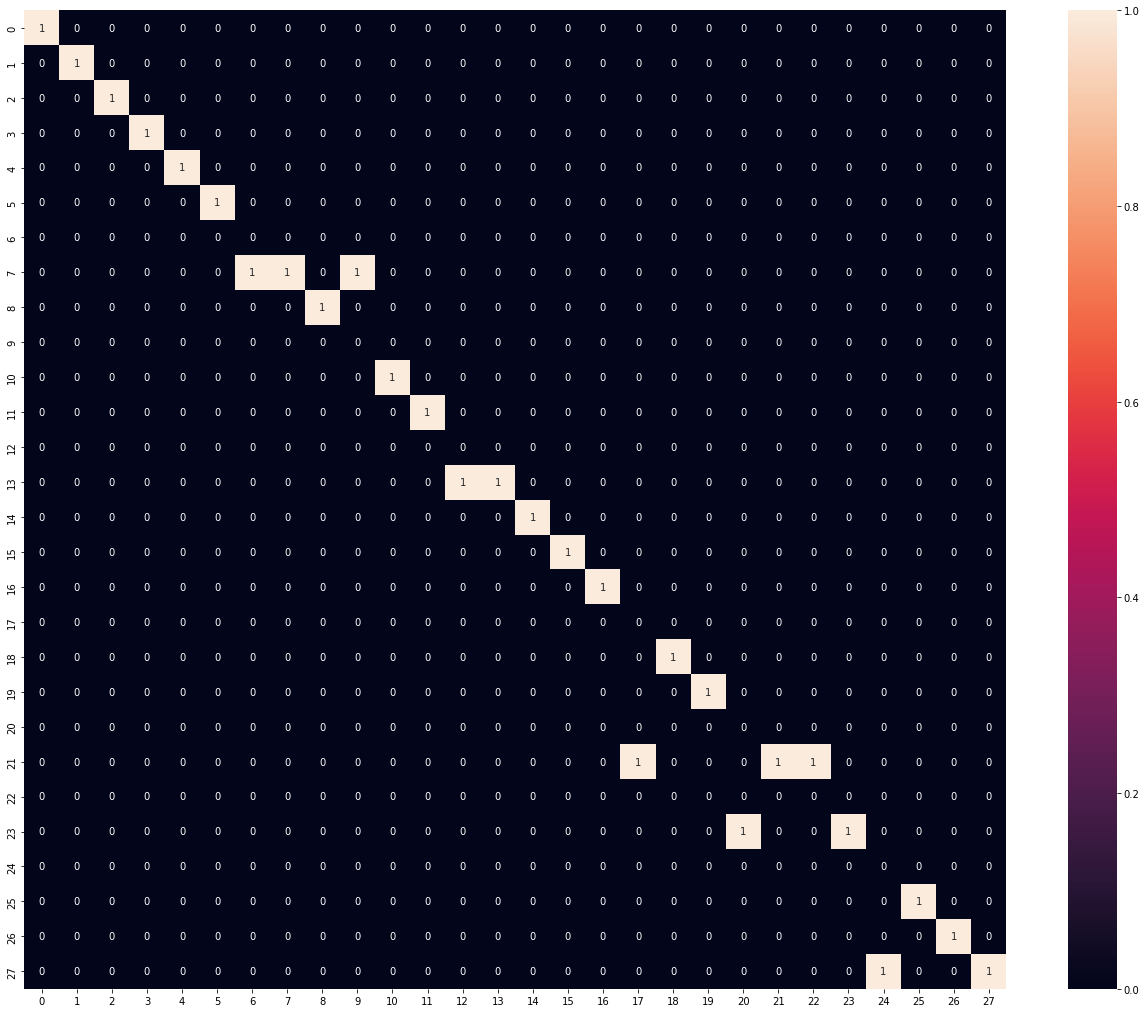

In [119]:
plt.figure(figsize=(22,18))
sns.heatmap(confusion_matrix_test, annot=True)
plt.show()

### Mean F1 score with 3 Convolutional Layers

In [123]:
np.mean(f1_score(pred_test,test_labels_list, average=None))

0.6785714285714286

### Predicting the test set labels using ResNet16 model

In [124]:
pred_test=[]
test_labels_list=[]
with torch.no_grad():
    correct = 0
    for (images,_),labels in zip(test_dataloader,test_labels):
        resnet_18.eval()
        images = images.to(device)
        output = resnet_18(images)
        prediction = torch.max(output,1)[1]
        pred_test.append(prediction.cpu().numpy()[0])
        correct += (prediction.cpu().numpy()[0] == labels)
        test_labels_list.append(labels)
    print("Accuracy :",(correct/len(test_dataloader.dataset))*100,"%")

Accuracy : 100.0 %


In [125]:
confusion_matrix_test=confusion_matrix(pred_test, test_labels_list)

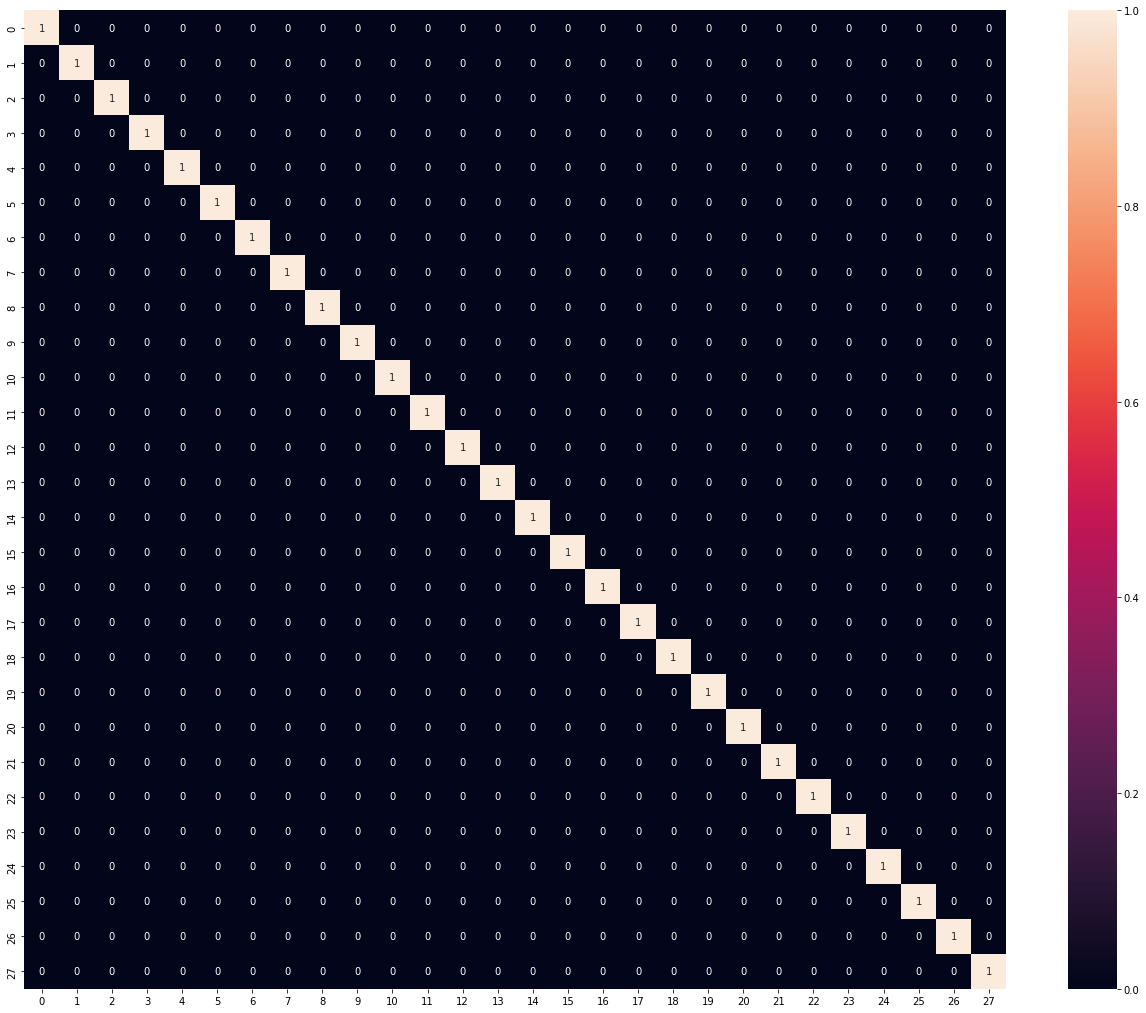

In [126]:
plt.figure(figsize=(22,18))
sns.heatmap(confusion_matrix_test, annot=True)
plt.show()

In [127]:
np.mean(f1_score(pred_test,test_labels_list, average=None))

1.0

### Finally, the model selected using model selection gives test set accuracy of 75 % and mean F1 score of 0.6785 But the test accuracy with the model trained using ResNet16 is 100 % and the corresponding mean F1 score is 1.